In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import PathologicalPartitioner
partitioner = PathologicalPartitioner(
    num_partitions=NUM_CLIENTS,
    partition_by="label",
    num_classes_per_partition=2,
    class_assignment_mode="random", # ['random', 'deterministic', 'first-deterministic']
    seed=42
)

In [ ]:
def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
test_accuracies = []
loss_values = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            loss_values.append(loss)
            print(f"Round {server_round}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1549) 2025-05-01 01:06:51.943299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1549) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1549) E0000 00:00:1746061611.968318    1549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1549) E0000 00:00:1746061611.976257    1549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 102595.37 examples/s]
(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Loss: 0.0691, Test Accuracy: 0.2176
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Loss: 0.0805, Test Accuracy: 0.2176
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Loss: 0.0749, Test Accuracy: 0.2126
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Loss: 0.0736, Test Accuracy: 0.2176
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
Round 5: Test Loss: 0.0667, Test Accuracy: 0.3265
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Loss: 0.0507, Test Accuracy: 0.3215
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Loss: 0.0545, Test Accuracy: 0.3215
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Loss: 0.0585, Test Accuracy: 0.3221
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Loss: 0.0733, Test Accuracy: 0.2179
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Loss: 0.0742, Test Accuracy: 0.2182
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Loss: 0.0745, Test Accuracy: 0.2268
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Loss: 0.0744, Test Accuracy: 0.2276
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Loss: 0.0456, Test Accuracy: 0.3620
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
Round 14: Test Loss: 0.0716, Test Accuracy: 0.2320


INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Loss: 0.0725, Test Accuracy: 0.2389
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
Round 16: Test Loss: 0.0438, Test Accuracy: 0.3994


INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Loss: 0.0700, Test Accuracy: 0.2677
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Loss: 0.0496, Test Accuracy: 0.3678
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Loss: 0.0702, Test Accuracy: 0.2707
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Loss: 0.0671, Test Accuracy: 0.2971
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Loss: 0.0693, Test Accuracy: 0.2733
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Loss: 0.0467, Test Accuracy: 0.3960
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
Round 23: Test Loss: 0.0426, Test Accuracy: 0.4394
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Loss: 0.0673, Test Accuracy: 0.3078
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Loss: 0.0398, Test Accuracy: 0.4816
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
Round 26: Test Loss: 0.0398, Test Accuracy: 0.4784
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
Round 27: Test Loss: 0.0665, Test Accuracy: 0.2982
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Loss: 0.0386, Test Accuracy: 0.4944
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) 
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
Round 29: Test Loss: 0.0643, Test Accuracy: 0.3151
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Loss: 0.0652, Test Accuracy: 0.3286
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Loss: 0.0612, Test Accuracy: 0.3796
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
Round 32: Test Loss: 0.0631, Test Accuracy: 0.3600
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Loss: 0.0358, Test Accuracy: 0.5403
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Loss: 0.0629, Test Accuracy: 0.3516
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Loss: 0.0339, Test Accuracy: 0.5703
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Loss: 0.0333, Test Accuracy: 0.5795
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Loss: 0.0399, Test Accuracy: 0.4963
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
Round 38: Test Loss: 0.0704, Test Accuracy: 0.2725
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Loss: 0.0658, Test Accuracy: 0.3212
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) 
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Loss: 0.0389, Test Accuracy: 0.5051
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Loss: 0.0336, Test Accuracy: 0.5638
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Loss: 0.0667, Test Accuracy: 0.2951
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Loss: 0.0347, Test Accuracy: 0.5432
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Test Loss: 0.0628, Test Accuracy: 0.3741
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Loss: 0.0644, Test Accuracy: 0.3639
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0
(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Loss: 0.0644, Test Accuracy: 0.3579
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Loss: 0.0630, Test Accuracy: 0.3726
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Loss: 0.0599, Test Accuracy: 0.4007
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8
(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Loss: 0.0350, Test Accuracy: 0.5602
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 3101585216857001770, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 11618766077839740809, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 7115386102617962194, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 4
(ClientAppActor pid=1549) Partition 4 size: 2501
(ClientAppActor pid=1549) Partition 4 train size: 2000
(ClientAppActor pid=1549) Partition 4 test size: 501


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 1997145124056624758, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13405950057151007220, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 0


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 0 size: 2501
(ClientAppActor pid=1549) Partition 0 train size: 2000
(ClientAppActor pid=1549) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 14967268978604211038, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 15826730232778528169, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 13263039276329505781, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 1


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Partition 1 size: 5000
(ClientAppActor pid=1549) Partition 1 train size: 4000
(ClientAppActor pid=1549) Partition 1 test size: 1000
(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 96777895667849459, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 9
(ClientAppActor pid=1549) Partition 9 size: 2499
(ClientAppActor pid=1549) Partition 9 train size: 1999
(ClientAppActor pid=1549) Partition 9 test size: 500


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(


(ClientAppActor pid=1549) Context data: {'run_id': 17423025977129849042, 'node_id': 6665218662813611088, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1549)   array_records={},
(ClientAppActor pid=1549)   metric_records={},
(ClientAppActor pid=1549)   config_records={}
(ClientAppActor pid=1549) ), 'run_config': {}}
(ClientAppActor pid=1549) Using partition_id: 8


(ClientAppActor pid=1549) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=1549)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 4723.42s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06905095548496513
INFO :      		round 2: 0.08050865733560053
INFO :      		round 3: 0.07491446849678011
INFO :      		round 4: 0.07363836250079923
INFO :      		round 5: 0.06670397145895662
INFO :      		round 6: 0.050703240979169895
INFO :      		round 7: 0.054520514295201106
INFO :      		round 8: 0.05

(ClientAppActor pid=1549) Partition 8 size: 2499
(ClientAppActor pid=1549) Partition 8 train size: 1999
(ClientAppActor pid=1549) Partition 8 test size: 500
Round 50: Test Loss: 0.0619, Test Accuracy: 0.3643


INFO :      		round 48: 0.0598829261859258
INFO :      		round 49: 0.035045365943642194
INFO :      		round 50: 0.061938433369000755
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.21755355954757152),
INFO :      	              (2, 0.2175535595475715),
INFO :      	              (3, 0.21255355954757152),
INFO :      	              (4, 0.2175535595475715),
INFO :      	              (5, 0.32653333333333334),
INFO :      	              (6, 0.32146427145708584),
INFO :      	              (7, 0.32146427145708584),
INFO :      	              (8, 0.3221333333333333),
INFO :      	              (9, 0.21788955422488357),
INFO :      	              (10, 0.2182222222222222),
INFO :      	              (11, 0.2267791084497671),
INFO :      	              (12, 0.2275568862275449),
INFO :      	              (13, 0.362),
INFO :      	              (14, 0.23199999999999998),
INFO :      	              (15, 0.23888223552894208),
INFO :      	              (16,

In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.2176
Round 2: 0.2176
Round 3: 0.2126
Round 4: 0.2176
Round 5: 0.3265
Round 6: 0.3215
Round 7: 0.3215
Round 8: 0.3221
Round 9: 0.2179
Round 10: 0.2182
Round 11: 0.2268
Round 12: 0.2276
Round 13: 0.3620
Round 14: 0.2320
Round 15: 0.2389
Round 16: 0.3994
Round 17: 0.2677
Round 18: 0.3678
Round 19: 0.2707
Round 20: 0.2971
Round 21: 0.2733
Round 22: 0.3960
Round 23: 0.4394
Round 24: 0.3078
Round 25: 0.4816
Round 26: 0.4784
Round 27: 0.2982
Round 28: 0.4944
Round 29: 0.3151
Round 30: 0.3286
Round 31: 0.3796
Round 32: 0.3600
Round 33: 0.5403
Round 34: 0.3516
Round 35: 0.5703
Round 36: 0.5795
Round 37: 0.4963
Round 38: 0.2725
Round 39: 0.3212
Round 40: 0.5051
Round 41: 0.5638
Round 42: 0.2951
Round 43: 0.5432
Round 44: 0.3741
Round 45: 0.3639
Round 46: 0.3579
Round 47: 0.3726
Round 48: 0.4007
Round 49: 0.5602
Round 50: 0.3643



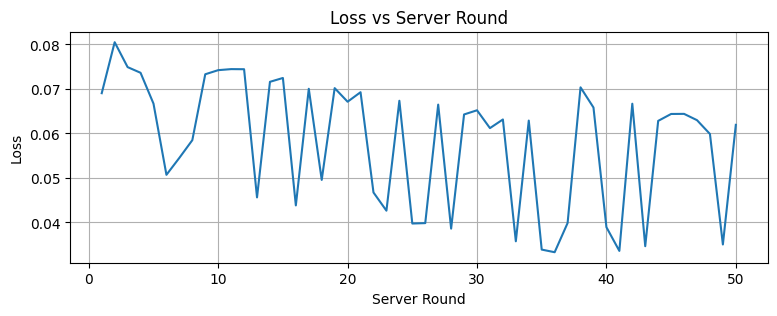

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(loss_values) + 1), loss_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

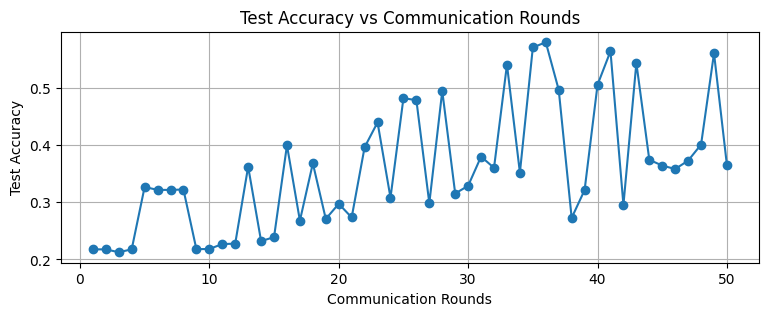

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

testm_accuracies = []
lossm_values = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            testm_accuracies.append(accuracy)
            lossm_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, #Learning rate
    server_momentum=0.9 #Momentum
)

def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=28150) 2025-05-01 02:26:06.044849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=28150) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=28150) E0000 00:00:1746066366.069452   28150 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=28150) E0000 00:00:1746066366.076227   28150 cuda_blas.cc:1418] Unable to register cuBLAS factor

(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) 
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Loss: 0.0663 Test Accuracy: 0.0000
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Loss: 0.0772 Test Accuracy: 0.4082
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Loss: 0.1209 Test Accuracy: 0.1887
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Loss: 0.0506 Test Accuracy: 0.3963
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Loss: 0.0494 Test Accuracy: 0.3779
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Loss: 0.0492 Test Accuracy: 0.3749
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Loss: 0.0443 Test Accuracy: 0.4371
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Loss: 0.0360 Test Accuracy: 0.5607
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Loss: 0.0501 Test Accuracy: 0.5069
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Loss: 0.0561 Test Accuracy: 0.3911
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Loss: 0.0320 Test Accuracy: 0.6393
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) 
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Loss: 0.0453 Test Accuracy: 0.4436
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Loss: 0.0372 Test Accuracy: 0.5450
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Loss: 0.0353 Test Accuracy: 0.5901
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Loss: 0.0386 Test Accuracy: 0.5542
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Loss: 0.0357 Test Accuracy: 0.5868
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Loss: 0.0461 Test Accuracy: 0.4721
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Loss: 0.0543 Test Accuracy: 0.3388
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Loss: 0.0344 Test Accuracy: 0.5824
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Loss: 0.0291 Test Accuracy: 0.6538
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Loss: 0.0334 Test Accuracy: 0.6098
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Loss: 0.0405 Test Accuracy: 0.5884
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Loss: 0.0444 Test Accuracy: 0.5662
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Loss: 0.0336 Test Accuracy: 0.5916
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Loss: 0.0364 Test Accuracy: 0.5572
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Loss: 0.0379 Test Accuracy: 0.5337
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
Round 27: Loss: 0.0416 Test Accuracy: 0.5587
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Loss: 0.0254 Test Accuracy: 0.6710
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Loss: 0.0469 Test Accuracy: 0.4079
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Loss: 0.0311 Test Accuracy: 0.6273
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Loss: 0.0323 Test Accuracy: 0.6111
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) 
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Loss: 0.0347 Test Accuracy: 0.6592
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Loss: 0.0253 Test Accuracy: 0.6825
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Loss: 0.0351 Test Accuracy: 0.5866
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Loss: 0.0285 Test Accuracy: 0.6638
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Loss: 0.0315 Test Accuracy: 0.6493
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Loss: 0.0321 Test Accuracy: 0.6444
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Loss: 0.0277 Test Accuracy: 0.6837
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Loss: 0.0255 Test Accuracy: 0.6915
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Loss: 0.0306 Test Accuracy: 0.6453
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Loss: 0.0308 Test Accuracy: 0.6268
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Loss: 0.0325 Test Accuracy: 0.6169
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) 
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Loss: 0.0268 Test Accuracy: 0.6866
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Loss: 0.0298 Test Accuracy: 0.6579
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Loss: 0.0372 Test Accuracy: 0.5800
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Loss: 0.0409 Test Accuracy: 0.5530
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
Round 47: Loss: 0.0216 Test Accuracy: 0.7333
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Loss: 0.0274 Test Accuracy: 0.6784
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Loss: 0.0239 Test Accuracy: 0.7267
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5929477426549430550, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 0


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 0 size: 2501
(ClientAppActor pid=28150) Partition 0 train size: 2000
(ClientAppActor pid=28150) Partition 0 test size: 501
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4497115085966263109, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 5434385440640199243, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 8276029223367555793, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 3


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 3 size: 3333
(ClientAppActor pid=28150) Partition 3 train size: 2666
(ClientAppActor pid=28150) Partition 3 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9039162698570969849, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 9473663961121369269, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 9


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 9 size: 2499
(ClientAppActor pid=28150) Partition 9 train size: 1999
(ClientAppActor pid=28150) Partition 9 test size: 500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 2577996781540897216, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 862572732750979366, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 6


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 6 size: 3333
(ClientAppActor pid=28150) Partition 6 train size: 2666
(ClientAppActor pid=28150) Partition 6 test size: 667
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 18428036217364484887, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500
(ClientAppActor pid=28150) Context data: {'run_id': 5771882806973924698, 'node_id': 4767897222975500777, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=28150)   array_records={},
(ClientAppActor pid=28150)   metric_records={},
(ClientAppActor pid=28150)   config_records={}
(ClientAppActor pid=28150) ), 'run_config': {}}
(ClientAppActor pid=28150) Using partition_id: 7


(ClientAppActor pid=28150) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=28150)   warnings.warn(


(ClientAppActor pid=28150) Partition 7 size: 7500
(ClientAppActor pid=28150) Partition 7 train size: 6000
(ClientAppActor pid=28150) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 5041.59s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06627696864515588
INFO :      		round 2: 0.0771506499935535
INFO :      		round 3: 0.12086327083037024
INFO :      		round 4: 0.05058573975212792
INFO :      		round 5: 0.049420583906854935
INFO :      		round 6: 0.049234628437226646
INFO :      		round 7: 0.04427043346434387
INFO :      		round 8: 0.0359967907911001
INFO :      		round 9: 0.05009351382371964
INFO :      		round 10: 0.05612672583971519
INFO :      		round 11: 0.032047804548991664
INFO :      		round 12: 0.04527443862852857
INFO :      		round 13: 0.03715670331980658
INFO :      		round 14: 0.035294126267459376
INFO :      		round 15: 0.03855920779907455
INFO :      		round 16: 0.03569888739403058
INFO :      		round 17: 0.04613076386551098
INFO :      		round 18: 0.05425596750024625
INFO :      		round 19:

Round 50: Loss: 0.0271 Test Accuracy: 0.6839


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(testm_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.0000
Round 2: 0.4082
Round 3: 0.1887
Round 4: 0.3963
Round 5: 0.3779
Round 6: 0.3749
Round 7: 0.4371
Round 8: 0.5607
Round 9: 0.5069
Round 10: 0.3911
Round 11: 0.6393
Round 12: 0.4436
Round 13: 0.5450
Round 14: 0.5901
Round 15: 0.5542
Round 16: 0.5868
Round 17: 0.4721
Round 18: 0.3388
Round 19: 0.5824
Round 20: 0.6538
Round 21: 0.6098
Round 22: 0.5884
Round 23: 0.5662
Round 24: 0.5916
Round 25: 0.5572
Round 26: 0.5337
Round 27: 0.5587
Round 28: 0.6710
Round 29: 0.4079
Round 30: 0.6273
Round 31: 0.6111
Round 32: 0.6592
Round 33: 0.6825
Round 34: 0.5866
Round 35: 0.6638
Round 36: 0.6493
Round 37: 0.6444
Round 38: 0.6837
Round 39: 0.6915
Round 40: 0.6453
Round 41: 0.6268
Round 42: 0.6169
Round 43: 0.6866
Round 44: 0.6579
Round 45: 0.5800
Round 46: 0.5530
Round 47: 0.7333
Round 48: 0.6784
Round 49: 0.7267
Round 50: 0.6839



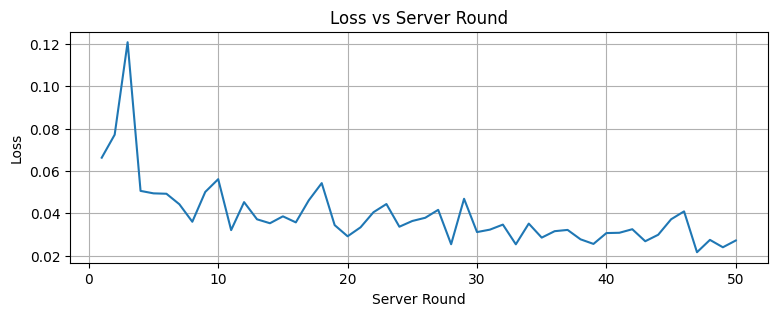

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossm_values) + 1), lossm_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

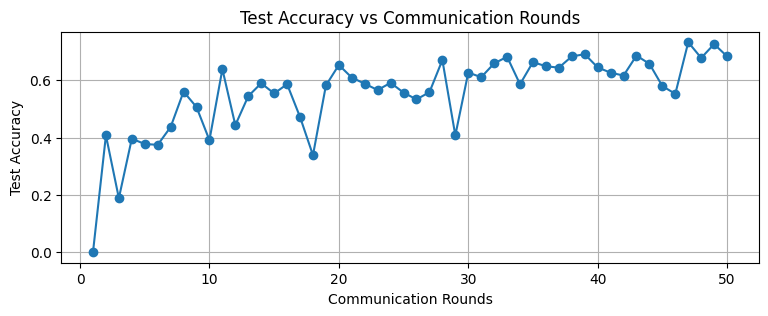

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

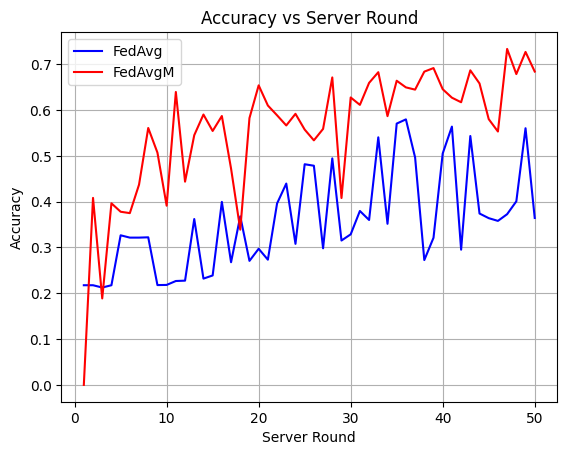

In [ ]:
def plot_accuracies():
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='FedAvg', color='blue', linestyle='-')
    plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, label='FedAvgM', color='red', linestyle='-')
    plt.title('Accuracy vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies()

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)

            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
from flwr.server.strategy import FedProx

fedprox_accuracies = []
lossp_values = []

class CustomFedProx(FedProx):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result = super().aggregate_evaluate(server_round, results, failures)

        if aggregated_result is not None:
            loss, metrics = aggregated_result
            accuracy = metrics.get("accuracy", 0.0)
            fedprox_accuracies.append(accuracy)
            lossp_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")

        return aggregated_result

In [ ]:
strategy_fedprox = CustomFedProx(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    proximal_mu=0.01
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy_fedprox, config=config)

server = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=56255) 2025-05-01 03:50:12.465433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=56255) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=56255) E0000 00:00:1746071412.505528   56255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=56255) E0000 00:00:1746071412.516975   56255 cuda_blas.cc:1418] Unable to register cuBLAS factor

(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Loss: 0.0519 Test Accuracy: 0.4617
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Loss: 0.0677 Test Accuracy: 0.4455
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Loss: 0.1646 Test Accuracy: 0.3650
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) 


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
Round 4: Loss: 0.0648 Test Accuracy: 0.4540
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Loss: 0.0444 Test Accuracy: 0.5367
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Loss: 0.0419 Test Accuracy: 0.5025
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) 
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Loss: 0.0352 Test Accuracy: 0.6462
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Loss: 0.0740 Test Accuracy: 0.4392
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Loss: 0.0637 Test Accuracy: 0.4300
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Loss: 0.0449 Test Accuracy: 0.5497
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Loss: 0.0462 Test Accuracy: 0.4226
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
Round 12: Loss: 0.0366 Test Accuracy: 0.5868


INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Loss: 0.0516 Test Accuracy: 0.4639
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Loss: 0.0502 Test Accuracy: 0.4471
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) 
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Loss: 0.0376 Test Accuracy: 0.5836
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
Round 16: Loss: 0.0339 Test Accuracy: 0.6386
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Loss: 0.0370 Test Accuracy: 0.5582
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Loss: 0.0346 Test Accuracy: 0.6128
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Loss: 0.0390 Test Accuracy: 0.5568
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2
(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) 
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Loss: 0.0242 Test Accuracy: 0.7356
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) 
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Loss: 0.0278 Test Accuracy: 0.6872
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Loss: 0.0266 Test Accuracy: 0.6902
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Loss: 0.0292 Test Accuracy: 0.6698
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
Round 24: Loss: 0.0333 Test Accuracy: 0.6194
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
Round 25: Loss: 0.0307 Test Accuracy: 0.6519
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Loss: 0.0277 Test Accuracy: 0.6938
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
Round 27: Loss: 0.0342 Test Accuracy: 0.6022
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Loss: 0.0283 Test Accuracy: 0.6808
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Loss: 0.0283 Test Accuracy: 0.6851
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Loss: 0.0256 Test Accuracy: 0.7128
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Loss: 0.0272 Test Accuracy: 0.6919
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Loss: 0.0275 Test Accuracy: 0.6905
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
Round 33: Loss: 0.0284 Test Accuracy: 0.6704
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Loss: 0.0252 Test Accuracy: 0.7235
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Loss: 0.0246 Test Accuracy: 0.7371
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Loss: 0.0250 Test Accuracy: 0.7195
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
Round 37: Loss: 0.0243 Test Accuracy: 0.7393
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Loss: 0.0244 Test Accuracy: 0.7312
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Loss: 0.0282 Test Accuracy: 0.6797
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Loss: 0.0227 Test Accuracy: 0.7609
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) 
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Loss: 0.0283 Test Accuracy: 0.6887
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Loss: 0.0266 Test Accuracy: 0.7096
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) 


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Loss: 0.0240 Test Accuracy: 0.7355
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Loss: 0.0209 Test Accuracy: 0.7773
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Loss: 0.0216 Test Accuracy: 0.7601
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Loss: 0.0263 Test Accuracy: 0.7092
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5
(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Loss: 0.0310 Test Accuracy: 0.6686
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Loss: 0.0249 Test Accuracy: 0.7331
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4
(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8
(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Loss: 0.0208 Test Accuracy: 0.7766
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 8799123684342292982, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 13665196709161354494, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2052794309136764877, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 7


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 7 size: 7500
(ClientAppActor pid=56255) Partition 7 train size: 6000
(ClientAppActor pid=56255) Partition 7 test size: 1500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 9154798825395339318, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 8


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 8 size: 2499
(ClientAppActor pid=56255) Partition 8 train size: 1999
(ClientAppActor pid=56255) Partition 8 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15197847533544958064, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 4


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 4 size: 2501
(ClientAppActor pid=56255) Partition 4 train size: 2000
(ClientAppActor pid=56255) Partition 4 test size: 501


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 2105372619036551105, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 16890591167544635806, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 6


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 6 size: 3333
(ClientAppActor pid=56255) Partition 6 train size: 2666
(ClientAppActor pid=56255) Partition 6 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 15620310991857326772, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 2


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 2 size: 3334
(ClientAppActor pid=56255) Partition 2 train size: 2667
(ClientAppActor pid=56255) Partition 2 test size: 667
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 5097857817558013821, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 1


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 1 size: 5000
(ClientAppActor pid=56255) Partition 1 train size: 4000
(ClientAppActor pid=56255) Partition 1 test size: 1000
(ClientAppActor pid=56255) Context data: {'run_id': 14858326453338536128, 'node_id': 14762624204318099705, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=56255)   array_records={},
(ClientAppActor pid=56255)   metric_records={},
(ClientAppActor pid=56255)   config_records={}
(ClientAppActor pid=56255) ), 'run_config': {}}
(ClientAppActor pid=56255) Using partition_id: 5


(ClientAppActor pid=56255) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=56255)   warnings.warn(


(ClientAppActor pid=56255) Partition 5 size: 2500
(ClientAppActor pid=56255) Partition 5 train size: 2000
(ClientAppActor pid=56255) Partition 5 test size: 500


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 4971.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.051898118466095856
INFO :      		round 2: 0.06770449361125143
INFO :      		round 3: 0.1645884460381057
INFO :      		round 4: 0.06484020570671072
INFO :      		round 5: 0.04439910786898258
INFO :      		round 6: 0.04186343746536826
INFO :      		round 7: 0.0351712967333818
INFO :      		round 8: 0.07403466233314217
INFO :      		round 9: 0.06365302314900682
INFO :      		round 10: 0.04494765709265859
INFO :      		round 11: 0.04620486410645975
INFO :      		round 12: 0.03657467663464733
INFO :      		round 13: 0.0515958986485317
INFO :      		round 14: 0.05024587429493091
INFO :      		round 15: 0.037631886349399214
INFO :      		round 16: 0.033924546265744274
INFO :      		round 17: 0.037047601344305674
INFO :      		round 18: 0.03461568827293316
INFO :      		round 19: 

Round 50: Loss: 0.0303 Test Accuracy: 0.6520


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(fedprox_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====



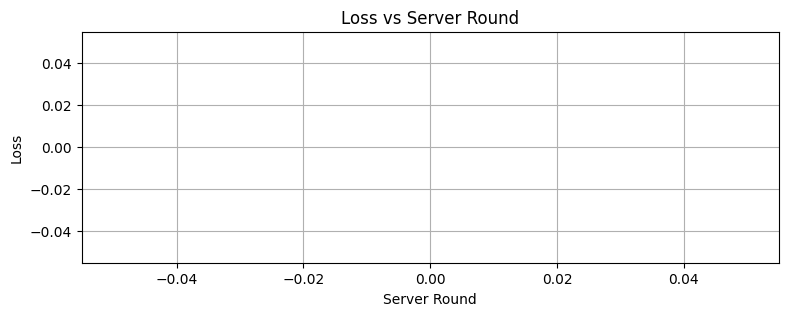

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossp_values) + 1), lossp_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

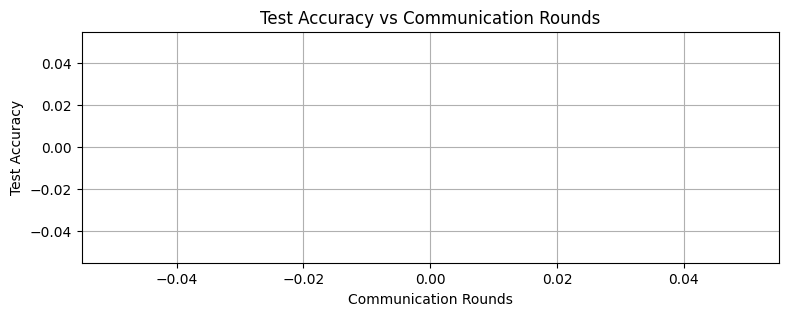

In [ ]:
def plot_accuracy_vs_rounds():
    if fedprox_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

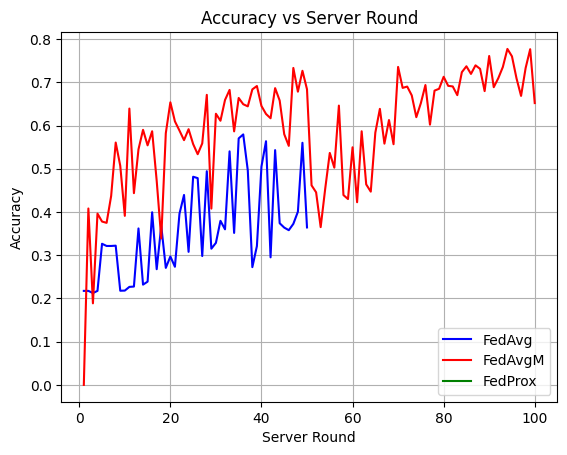

In [ ]:
def plot_accuracies():
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='FedAvg', color='blue', linestyle='-')
    plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, label='FedAvgM', color='red', linestyle='-')
    plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, label='FedProx', color='green', linestyle='-')

    plt.title('Accuracy vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies()

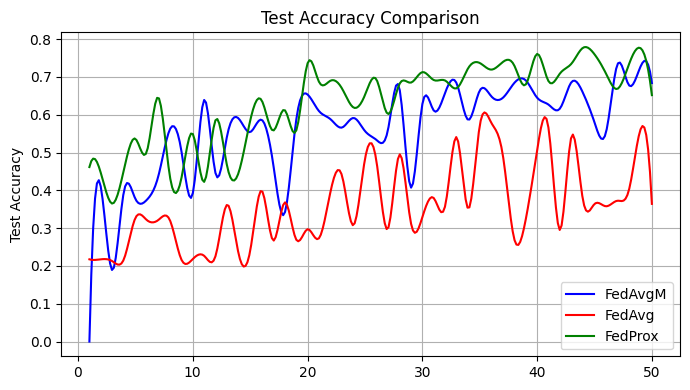

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Accuracy values
fedavgm = [0.0000, 0.4082, 0.1887, 0.3963, 0.3779, 0.3749, 0.4371, 0.5607, 0.5069, 0.3911,
           0.6393, 0.4436, 0.5450, 0.5901, 0.5542, 0.5868, 0.4721, 0.3388, 0.5824, 0.6538,
           0.6098, 0.5884, 0.5662, 0.5916, 0.5572, 0.5337, 0.5587, 0.6710, 0.4079, 0.6273,
           0.6111, 0.6592, 0.6825, 0.5866, 0.6638, 0.6493, 0.6444, 0.6837, 0.6915, 0.6453,
           0.6268, 0.6169, 0.6866, 0.6579, 0.5800, 0.5530, 0.7333, 0.6784, 0.7267, 0.6839]

fedavg = [0.2176, 0.2176, 0.2126, 0.2176, 0.3265, 0.3215, 0.3215, 0.3221, 0.2179, 0.2182,
          0.2268, 0.2276, 0.3620, 0.2320, 0.2389, 0.3994, 0.2677, 0.3678, 0.2707, 0.2971,
          0.2733, 0.3960, 0.4394, 0.3078, 0.4816, 0.4784, 0.2982, 0.4944, 0.3151, 0.3286,
          0.3796, 0.3600, 0.5403, 0.3516, 0.5703, 0.5795, 0.4963, 0.2725, 0.3212, 0.5051,
          0.5638, 0.2951, 0.5432, 0.3741, 0.3639, 0.3579, 0.3726, 0.4007, 0.5602, 0.3643]

fedprox = [0.4617, 0.4455, 0.3650, 0.4540, 0.5367, 0.5025, 0.6462, 0.4392, 0.4300, 0.5497,
           0.4226, 0.5868, 0.4639, 0.4471, 0.5836, 0.6386, 0.5582, 0.6128, 0.5568, 0.7356,
           0.6872, 0.6902, 0.6698, 0.6194, 0.6519, 0.6938, 0.6022, 0.6808, 0.6851, 0.7128,
           0.6919, 0.6905, 0.6704, 0.7235, 0.7371, 0.7195, 0.7393, 0.7312, 0.6797, 0.7609,
           0.6887, 0.7096, 0.7355, 0.7773, 0.7601, 0.7092, 0.6686, 0.7331, 0.7766, 0.6520]

rounds = np.array(range(1, 51))

# Create smoother curves
def smooth_curve(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Smooth data
x_fam, y_fam = smooth_curve(rounds, np.array(fedavgm))
x_fa, y_fa = smooth_curve(rounds, np.array(fedavg))
x_fp, y_fp = smooth_curve(rounds, np.array(fedprox))

# Plotting
plt.figure(figsize=(7,4))
plt.plot(x_fam, y_fam, label='FedAvgM', color='blue')
plt.plot(x_fa, y_fa, label='FedAvg', color='red')
plt.plot(x_fp, y_fp, label='FedProx', color='green')

# Decorations
plt.title('Test Accuracy Comparison')
plt.xlabel('')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


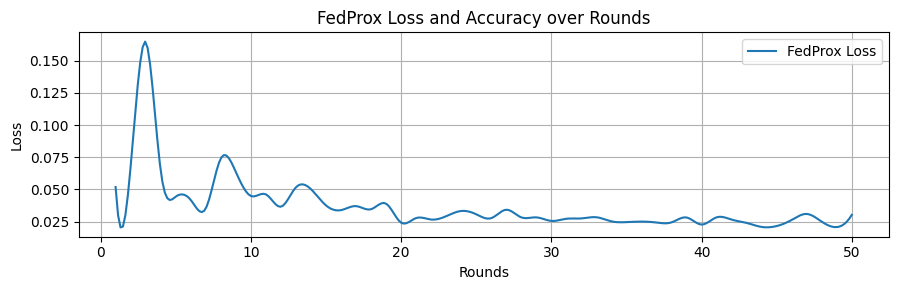

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# FedProx Loss values
fedprox_loss = [
    0.051898118466095856, 0.06770449361125143, 0.1645884460381057, 0.06484020570671072,
    0.04439910786898258, 0.04186343746536826, 0.0351712967333818, 0.07403466233314217,
    0.06365302314900682, 0.04494765709265859, 0.04620486410645975, 0.03657467663464733,
    0.0515958986485317, 0.05024587429493091, 0.037631886349399214, 0.033924546265744274,
    0.037047601344305674, 0.03461568827293316, 0.03896539056486111, 0.024213911504494406,
    0.027767260090399634, 0.026607273813855626, 0.029187269620492978, 0.03326122109466874,
    0.030714542988378772, 0.027680836095097538, 0.03424280989491016, 0.028296699838379274,
    0.028300968608339794, 0.02555183854231429, 0.02721279631002678, 0.027473973573746934,
    0.028393626769958956, 0.02522415867616585, 0.024607221770739263, 0.025024599190910678,
    0.024295286895745654, 0.024414130089281533, 0.028221044226744478, 0.02272642414951568,
    0.028333489402167896, 0.026566893565376982, 0.023988087630426855, 0.020864716122309022,
    0.021573207713771303, 0.026319892085040566, 0.0309550817086036, 0.02494750372829616,
    0.02075314225458929, 0.030266895909726994
]



# Create x-axis (rounds)
rounds = np.arange(1, 51)

# Smoothing function
def smooth(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    return x_new, y_smooth

# Smooth the curves
x_loss, y_loss = smooth(rounds, np.array(fedprox_loss))

# Plotting
plt.figure(figsize=(9,3))
plt.plot(x_loss, y_loss, label="FedProx Loss")
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("FedProx Loss and Accuracy over Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


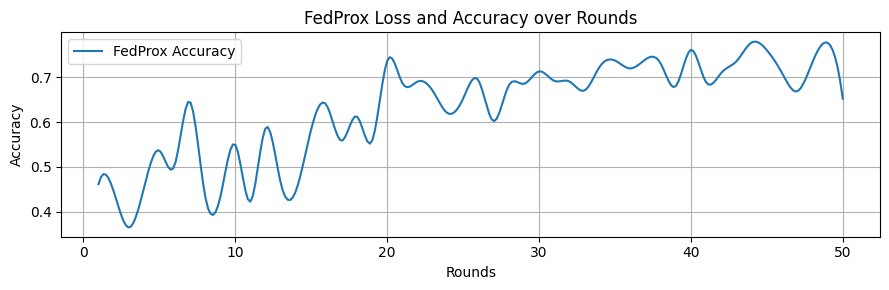

In [ ]:
# FedProx Accuracy values
fedprox_accuracy = [
    0.46166902201356774, 0.4455431864275867, 0.3650428943878028, 0.4539986181284745,
    0.5366803086739906, 0.502531977254616, 0.646191867926551, 0.43922264088801033,
    0.4300069142922607, 0.5497146599114235, 0.42261629424808556, 0.5867791306184612,
    0.4638857034465892, 0.44711651721309154, 0.583565800865369, 0.6386082080534764,
    0.5581957129543337, 0.6128208576960591, 0.5568357622115391, 0.735624766129332,
    0.6871750966700051, 0.6901885251263962, 0.6697861844939598, 0.6194110512311413,
    0.6519426753689023, 0.6937735836777482, 0.6021539283637449, 0.6808352976796274,
    0.6850864223294523, 0.7128202239381126, 0.6918896778026081, 0.6905242676368291,
    0.6703516948422341, 0.7235114774328714, 0.7371201232034471, 0.7194839446544193,
    0.7393394235683223, 0.7311798376570543, 0.6797348505447283, 0.7609352338119196,
    0.6887425383176083, 0.7096271403885549, 0.7355061642732351, 0.7772948802977636,
    0.7601423956019329, 0.7091866112398346, 0.6685990088491653, 0.7330647733984247,
    0.7766227603276603, 0.6520498995785126
]
# Create x-axis (rounds)
rounds = np.arange(1, 51)

# Smoothing function
def smooth(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    return x_new, y_smooth


x_acc, y_acc = smooth(rounds, np.array(fedprox_accuracy))

# Plotting
plt.figure(figsize=(9, 3))
plt.plot(x_acc, y_acc, label="FedProx Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("FedProx Loss and Accuracy over Rounds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
